## Part 1

In [33]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [34]:
# DEVICE = "cuda" if torch.cuda.is_available else "cpu"
DEVICE = "cpu"
MODEL_NAME = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, output_hidden_states = True).to(DEVICE).eval()


In [35]:
def run_logitlens(model, tokenizer, prompt, top_k=5, device=DEVICE):
    #token -> tensor
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    ##forward pass to get all hidden states
    with torch.no_grad():
        outputs = model(**inputs)   
    hidden_states = outputs.hidden_states

    W_U = model.lm_head.weight
    final_norm = model.transformer.ln_f
    results = []

    for layer_idx in range(1, len(hidden_states)):
        h = hidden_states[layer_idx]
        h_last = h[0, -1]   
        
        h_norm = final_norm(h_last)

        logits = torch.matmul(W_U, h_norm)
        probs = torch.softmax(logits, dim=-1)

        top_probs, top_indices = torch.topk(probs, k=top_k)
        top_tokens = [tokenizer.decode([idx.item()]) for idx in top_indices]

        results.append({
            "layer": layer_idx,
            "tokens": top_tokens,
            "probs": top_probs.cpu().tolist()
        })

    return results


In [36]:
def print_logitlens_results(results, prompt):
    print(f"\nPrompt: {prompt}\n")
    for r in results:
        layer = r["layer"]
        toks = r["tokens"]
        probs = r["probs"]

        pretty = [f"{tok.strip() or repr(tok)} ({p:.3f})"
                  for tok, p in zip(toks, probs)]
        print(f"Layer {layer:2d}: " + " | ".join(pretty))


In [37]:
import matplotlib.pyplot as plt
import numpy as np

In [38]:
def heatmap_matrix(results, top_k=5):
    fl_tokens = results[-1]["tokens"][:top_k]
    heat = np.zeros((top_k, len(results)))
    
    # 填矩阵：行=token，列=layer
    for layer_idx, layer_info in enumerate(results):
        layer_tokens = layer_info["tokens"]
        layer_probs = layer_info["probs"]
        
        for i, token in enumerate(fl_tokens):
            if token in layer_tokens:
                token_pos = layer_tokens.index(token)
                heat[i, layer_idx] = layer_probs[token_pos]
            else:
                heat[i, layer_idx] = 0.0
        
    return fl_tokens, heat

In [39]:
def plot_logitlens_heatmap(tokens, heat, figsize=(10, 5)):
    num_tokens, num_layers = heat.shape

    plt.figure(figsize=figsize)
    plt.imshow(heat, aspect="auto", cmap="viridis")

    # y 轴：token 名字
    plt.yticks(range(num_tokens), tokens, fontsize=12)

    # x 轴：layer index
    plt.xticks(range(num_layers), range(1, num_layers+1), fontsize=10)
    plt.xlabel("Layer", fontsize=14)
    plt.ylabel("Token", fontsize=14)
    plt.title("LogitLens Heatmap (Top-k Token Probabilities per Layer)", fontsize=16)

    plt.colorbar(label="Probability")
    plt.tight_layout()
    plt.show()



Prompt: Hello, my name is

Layer  1: not (0.288) | a (0.068) | still (0.068) | now (0.053) | also (0.045)
Layer  2: not (0.410) | now (0.204) | still (0.100) | also (0.057) | a (0.016)
Layer  3: not (0.324) | now (0.287) | still (0.059) | definitely (0.053) | also (0.044)
Layer  4: now (0.296) | still (0.126) | not (0.096) | a (0.073) | currently (0.048)
Layer  5: not (0.265) | now (0.201) | still (0.118) | a (0.096) | important (0.024)
Layer  6: a (0.316) | not (0.086) | now (0.085) | still (0.047) | my (0.047)
Layer  7: my (0.286) | a (0.098) | not (0.034) | Aaron (0.029) | Commander (0.026)
Layer  8: my (0.117) | Jack (0.082) | Am (0.072) | Dan (0.050) | Daniel (0.029)
Layer  9: Tom (0.097) | John (0.072) | David (0.063) | Jack (0.052) | Aaron (0.051)
Layer 10: Tom (0.074) | Daniel (0.063) | John (0.063) | Benjamin (0.041) | Aaron (0.037)
Layer 11: Tom (0.026) | John (0.025) | Daniel (0.021) | Jack (0.019) | Michael (0.015)
Layer 12: the (0.021) | , (0.020) | '\n' (0.014) | and (0.

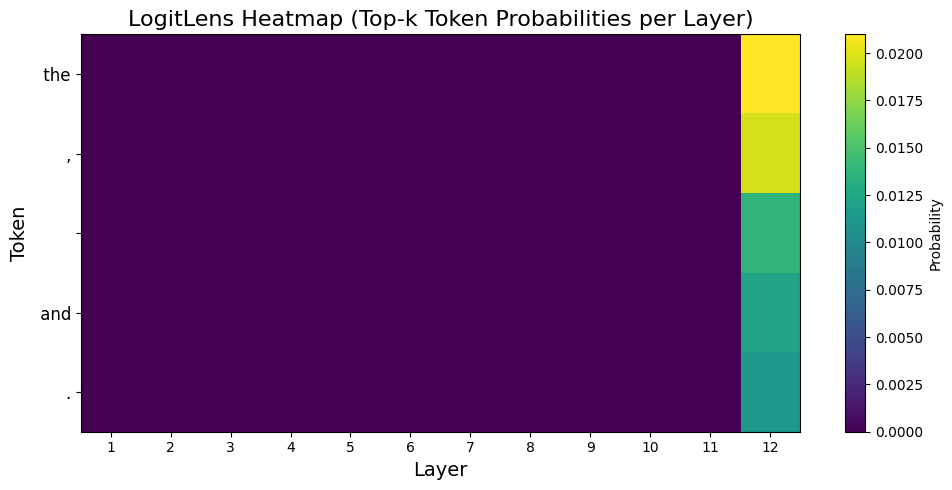

In [40]:
prompt = "Hello, my name is"
results = run_logitlens(model, tokenizer, prompt, top_k=5)
print_logitlens_results(results, prompt)


tokens, heat = heatmap_matrix(results, top_k=5)

plot_logitlens_heatmap(tokens, heat)

In [41]:
inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    out = model(**inputs)

top_probs, top_indices = torch.topk(out.logits[0, -1], k=5)

print("REAL MODEL top-5 prediction:")
for idx, p in zip(top_indices, top_probs):
    print(tokenizer.decode([idx.item()]), float(p))


REAL MODEL top-5 prediction:
 John -64.44324493408203
 K -64.63304901123047
 J -64.70594024658203
 Michael -64.82551574707031
 L -64.8592529296875


### exercise 1.2

In [52]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "Qwen/Qwen1.5-0.5B"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float32,
    output_hidden_states=True,   # 关键
)
model.eval()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1024, out_features=2816, bias=False)
          (up_proj): Linear(in_features=1024, out_features=2816, bias=False)
          (down_proj): Linear(in_features=2816, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
    )
    (norm): Qwen2RMSNorm()
  )
  (lm_head): Line

In [ ]:
def run_logitlens_qwen(model, tokenizer, prompt, top_k=5, device="cpu"):
    """
    在 Qwen/Qwen1.5-0.5B 上运行 LogitLens。
    """
    # 1. prompt -> tensor
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # 2. 模型前向传播（拿到 hidden states）
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.hidden_states  # [emb, layer1, ..., layerL]

    # 3. 找出 unembedding matrix 和最终 RMSNorm
    W_U = model.lm_head.weight            # [vocab, d_model]
    final_norm = model.model.norm   # LLaMA-style RMSNorm# ✅ Qwen2 的 final norm 在 model.model.norm

    results = []

    # 4. 对每一层进行 LogitLens
    for layer_idx in range(1, len(hidden_states)):
        h = hidden_states[layer_idx]       # [1, seq_len, d_model]
        h_last = h[0, -1]                  # 取最后一个 token 的hidden

        # A: 应用最终的 RMSNorm
        h_norm = final_norm(h_last)

        # B: unembedding → logits
        logits = torch.matmul(W_U, h_norm)   # [vocab]
        probs = torch.softmax(logits, dim=-1)

        # C: top-k token
        top_probs, top_indices = torch.topk(probs, k=top_k)
        top_tokens = [tokenizer.decode([idx.item()]) for idx in top_indices]

        results.append({
            "layer": layer_idx,
            "tokens": top_tokens,
            "probs": top_probs.cpu().tolist(),
        })

    return results



Prompt: La capitale de la France est

Layer  1: ABL (0.101) | udiante (0.035) | 眉 (0.019) | 毫无疑问 (0.010) | ponent (0.009)
Layer  2: 廓 (0.113) | udiante (0.048) | 豉 (0.039) | 天然 (0.017) | udiantes (0.017)
Layer  3: KHTML (0.078) | 为空 (0.042) | 一侧 (0.030) | 豉 (0.018) | udiante (0.018)
Layer  4: 一侧 (0.027) | KHTML (0.008) | 为空 (0.005) | "', (0.004) | 廓 (0.003)
Layer  5: KHTML (0.089) | 为空 (0.068) | 豉 (0.047) | � (0.015) | rength (0.012)
Layer  6: KHTML (0.026) | tabIndex (0.020) | � (0.018) | 一侧 (0.017) | 拍 (0.012)
Layer  7: tabIndex (0.045) | aurant (0.037) | .ToolTip (0.017) | bitten (0.015) | KHTML (0.014)
Layer  8: KHTML (0.072) | tabIndex (0.031) | 拍 (0.016) | .ToolTip (0.015) | aurant (0.015)
Layer  9: ikon (0.021) | .ToolTip (0.019) | based (0.015) | 理工 (0.011) | 未必 (0.009)
Layer 10: based (0.027) | 拍 (0.027) | 未必 (0.024) | Fonts (0.017) | 鞣 (0.015)
Layer 11: 未必 (0.033) | 拍 (0.031) | EMPL (0.022) | IPv (0.010) | 鞣 (0.008)
Layer 12: IPv (0.061) | EMPL (0.050) | ADR (0.024) | DIG (0

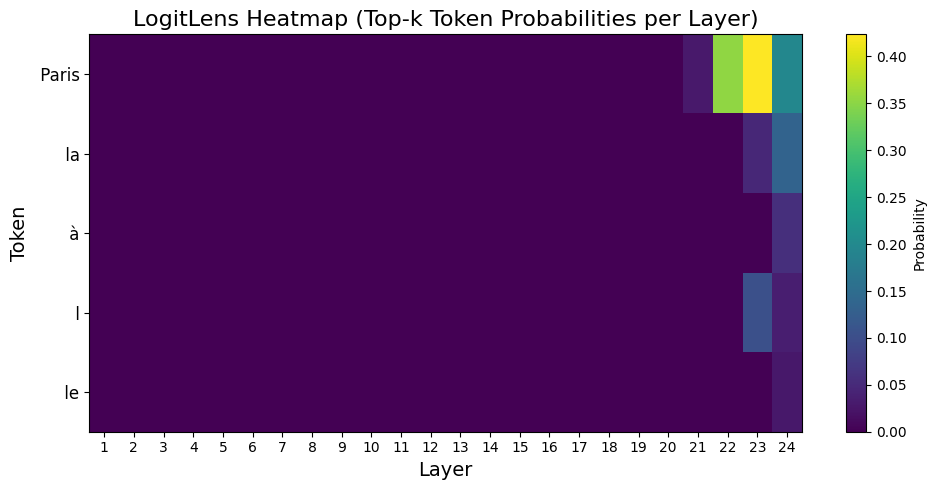

In [57]:
prompt = "La capitale de la France est"
results = run_logitlens_qwen(model, tokenizer, prompt)
print_logitlens_results(results, prompt)

tokens, heat = heatmap_matrix(results, top_k=5)
plot_logitlens_heatmap(tokens, heat)


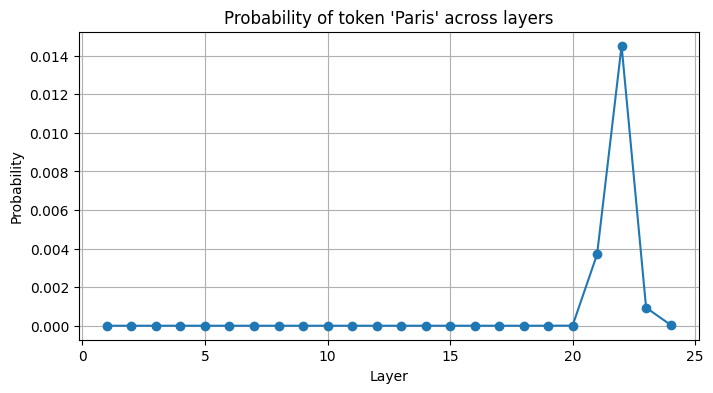

[7.74648469814565e-07,
 1.6144920778060623e-07,
 1.0468973243860091e-07,
 1.1243993185416912e-06,
 1.6809457292765728e-07,
 1.516233822940194e-07,
 8.363735304328657e-08,
 7.039380633955261e-09,
 1.725530651697227e-08,
 2.3536907534094098e-08,
 1.0497227975747592e-07,
 2.2156515910864982e-07,
 3.272265018949838e-07,
 2.6818233322956075e-07,
 1.4571674000762869e-07,
 2.946037795936718e-07,
 2.7820360060104576e-07,
 5.062027526037127e-07,
 6.300526251834526e-07,
 5.318142029864248e-06,
 0.0037007618229836226,
 0.014524471946060658,
 0.0009376501548103988,
 4.30624968430493e-05]

In [59]:
import matplotlib.pyplot as plt
import torch

def plot_token_probability_curve(model, tokenizer, prompt, target_token, device="cpu"):
    """
    绘制目标 token（如 'Paris'）在每一层中的 LogitLens 概率变化曲线。
    """
    # 1. 构造输入
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # 2. 前向传播，获取 hidden_states
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.hidden_states  # [emb, layer1, ..., layerL]

    # 3. unembedding matrix & final norm
    W_U = model.lm_head.weight
    final_norm = model.model.norm

    # 4. 获取目标 token 的 id
    target_id = tokenizer.encode(target_token, add_special_tokens=False)[0]

    # 保存每一层的概率
    prob_curve = []

    # 5. 对每一层计算目标 token 的概率
    for layer_idx in range(1, len(hidden_states)):
        h = hidden_states[layer_idx]        # [1, seq_len, d_model]
        h_last = h[0, -1]                   # 最后一个 token

        # 归一化
        h_norm = final_norm(h_last)

        # logits
        logits = torch.matmul(W_U, h_norm)
        probs = torch.softmax(logits, dim=-1)

        # 取出目标 token 的概率
        prob_curve.append(probs[target_id].item())

    # 6. 绘图
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(prob_curve) + 1), prob_curve, marker="o")
    plt.title(f"Probability of token '{target_token}' across layers")
    plt.xlabel("Layer")
    plt.ylabel("Probability")
    plt.grid(True)
    plt.show()

    return prob_curve


prompt = "La capitale de la France est"
plot_token_probability_curve(model, tokenizer, prompt, target_token="Paris")
